# Portfolio: Sarcasm Detection in News Headlines

## 1. Introduction & Conceptual Understanding
Sarcasm detection is a challenging Natural Language Processing (NLP) classification problem. Unlike standard sentiment analysis (where words like "bad" or "happy" are strong indicators), sarcasm relies heavily on nuance, world knowledge, and specific phrasing. 

**Hypothesis:**
Standard text cleaning pipelines usually strip out punctuation and remove "stop words" (common words like "the", "is", "at"). However, my hypothesis is that for sarcasm detection, these elements are crucial. Comedic timing and sarcastic delivery often rely on specific structures (e.g., "Area Man..."). Therefore, I am intentionally *keeping* stop words and punctuation, and using N-grams to capture phrases rather than just isolated words.

## 2. Exploratory Data Analysis (EDA) & Data Loading

**Technical Implementation:**
To ensure this notebook is fully reproducible, I am using a relative path to load the "News Headlines Dataset for Sarcasm Detection" (Kaggle). This dataset contains ~28,000 headlines from *The Onion* (satire/sarcastic) and *HuffPost* (serious). 

Below, we load the data and visualize:
1. The class balance (to ensure our model won't be biased toward one class).
2. The distribution of headline lengths.
3. The most frequent N-grams (phrases) in both classes using a `CountVectorizer`, which will visually prove my hypothesis that bigrams matter.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Makes charts prettier
sns.set_style("whitegrid")

# 1. Load the dataset
file_path = "data/Sarcasm_Headlines_Dataset_v2.json"
df = pd.read_json(file_path, lines=True)

# Drop the 'article_link' column since we only need text for NLP
df = df.drop('article_link', axis=1)

# Quick look at the head of the dataset
print(f"Dataset Size: {df.shape[0]} rows")
display(df.head())

Dataset Size: 28619 rows


,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


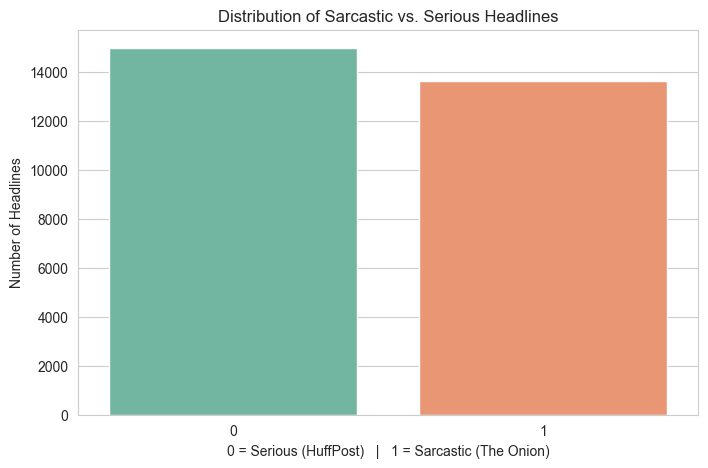

In [9]:
# 2. Check Class Balance
# It's important to know if we have roughly equal amounts of serious vs. sarcastic text
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='is_sarcastic', 
    hue='is_sarcastic', 
    palette='Set2', 
    legend=False
)
plt.title("Distribution of Sarcastic vs. Serious Headlines")
plt.xlabel("0 = Serious (HuffPost)   |   1 = Sarcastic (The Onion)")
plt.ylabel("Number of Headlines")
plt.show()

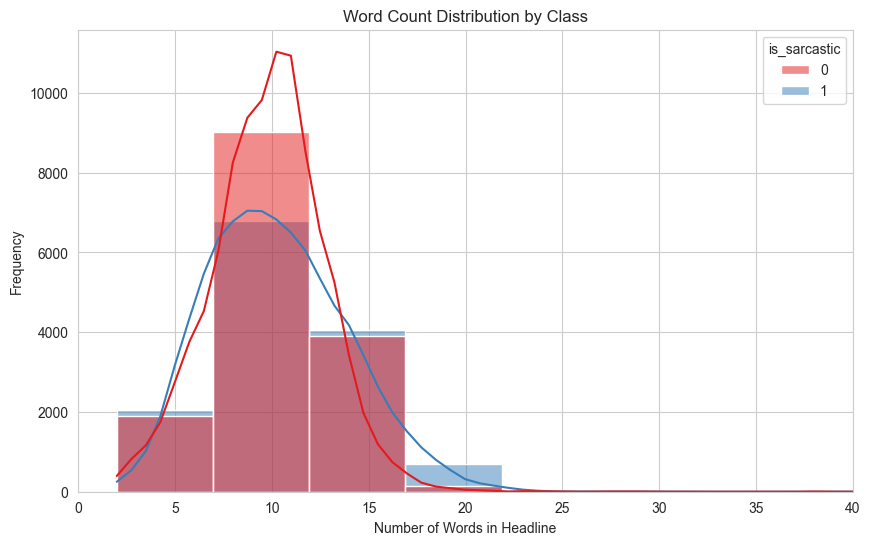

In [ ]:
# 3. Analyze Headline Lengths
# Do sarcastic headlines tend to be longer or shorter?
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df, 
    x='word_count', 
    hue='is_sarcastic', 
    kde=True, 
    bins=30, 
    palette='Set1'
)
plt.title("Word Count Distribution by Class")
plt.xlabel("Number of Words in Headline")
plt.ylabel("Frequency")
plt.xlim(0, 40)
plt.show()

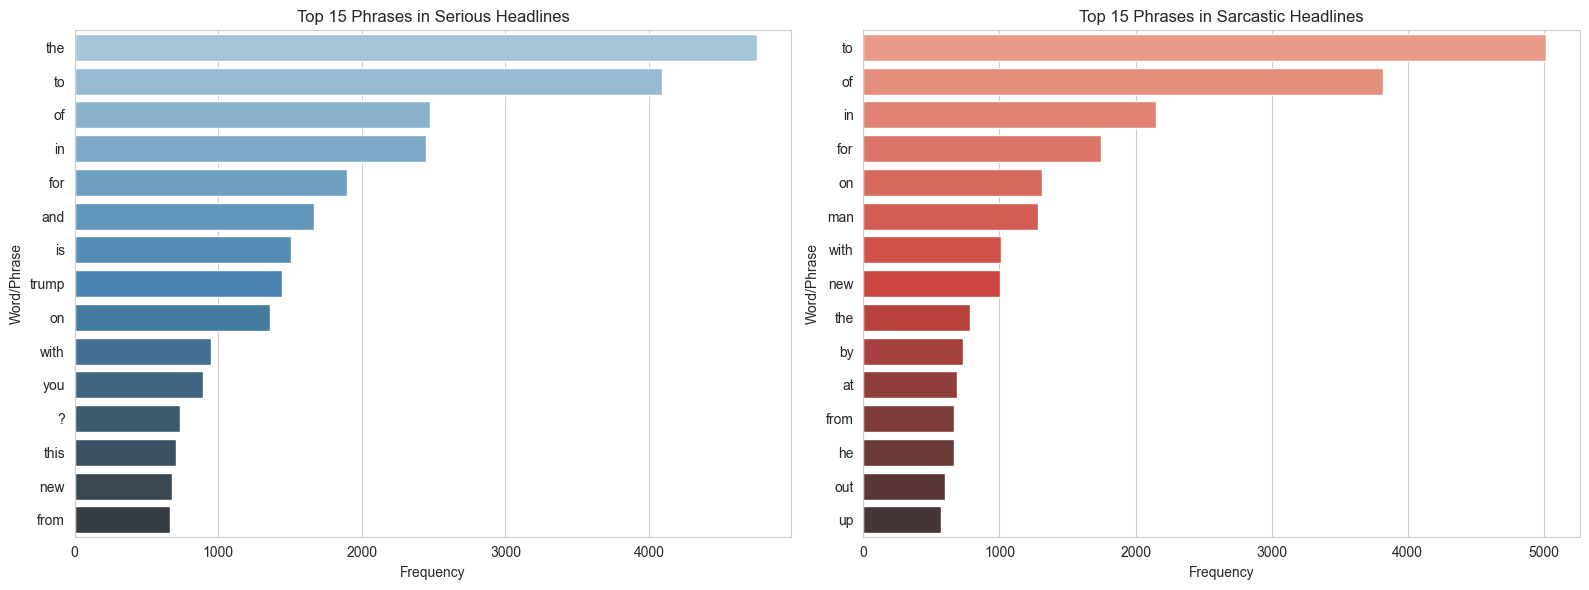

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Define our custom token pattern
# IT'S IMPORTANT TO INCLUDE PUNCTUATION AS TOKENS BECAUSE THEY CAN BE KEY INDICATORS OF SARCASTIC TONE 
# (LIKE EXCLAMATION MARKS OR ELLIPSES)!
custom_token_pattern = r'(?u)\b\w\w+\b|!|\?|\.\.\.'

def get_top_n_words(corpus, n=None):
    """
    Helper function to get the top N most common words/bigrams from a text corpus.
    """
    vec = CountVectorizer(
        ngram_range=(1, 2), 
        token_pattern=custom_token_pattern,
        stop_words=None # Keeping stop words to prove my hypothesis!
    ).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# 1. Get top 15 words/bigrams for Serious Headlines (Class 0)
serious_headlines = df[df['is_sarcastic'] == 0]['headline']
common_words_serious = get_top_n_words(serious_headlines, 15)
df_serious_words = pd.DataFrame(common_words_serious, columns=['Word/Phrase', 'Frequency'])

# 2. Get top 15 words/bigrams for Sarcastic Headlines (Class 1)
sarcastic_headlines = df[df['is_sarcastic'] == 1]['headline']
common_words_sarcastic = get_top_n_words(sarcastic_headlines, 15)
df_sarcastic_words = pd.DataFrame(common_words_sarcastic, columns=['Word/Phrase', 'Frequency'])

# 3. Plot the results side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Serious Headlines
sns.barplot(
    data=df_serious_words, 
    x='Frequency', 
    y='Word/Phrase', 
    ax=axes[0], 
    hue='Word/Phrase', 
    palette='Blues_d', 
    legend=False
)
axes[0].set_title('Top 15 Phrases in Serious Headlines')

# Plot for Sarcastic Headlines
sns.barplot(
    data=df_sarcastic_words, 
    x='Frequency', 
    y='Word/Phrase', 
    ax=axes[1], 
    hue='Word/Phrase', 
    palette='Reds_d', 
    legend=False
)
axes[1].set_title('Top 15 Phrases in Sarcastic Headlines')

plt.tight_layout()
plt.show()

## 3. Text Preprocessing & Feature Engineering

Here, we prepare the text for our Machine Learning model. 

**Methodology:**
* **TF-IDF (Term Frequency-Inverse Document Frequency):** We use this instead of a simple count vectorizer for modeling to penalize words that appear frequently across *all* headlines, helping the model focus on unique sarcastic identifiers.
* **`ngram_range=(1, 2)`:** Captures both unigrams (1-word) and bigrams (2-words).
* **`min_df=5`:** Filters out extremely rare words or typos (must appear in at least 5 headlines).
* **`stop_words=None`:** We keep common words to preserve the structural integrity of the jokes.
* **Custom Token Pattern:** `r'(?u)\b\w\w+\b|!|\?|\.\.\.'` ensures we keep exclamation points, question marks, and ellipses as distinct tokens.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Sarcasm-Specific Cleaning
custom_token_pattern = r'(?u)\b\w\w+\b|!|\?|\.\.\.'

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),        # Use 1-grams AND 2-grams
    min_df=5,                  # Ignore words/phrases that appear in less than 5 headlines
    token_pattern=custom_token_pattern,
    stop_words=None            # Keep stop words!
)

# Transform the text
X = vectorizer.fit_transform(df['headline'])
y = df['is_sarcastic']

print(f"New Vocabulary Size: {len(vectorizer.get_feature_names_out())}")

# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

New Vocabulary Size: 12630


## 4. Model Training

With our features vectorized, we train a Logistic Regression classifier. 

**Technical Implementation Details:**
I split the data using an 80/20 train/test split to evaluate performance on unseen data & I chose Logistic Regression for its interpretability and speed with sparse matrices (like TF-IDF outputs). I also increased `max_iter=1000` to ensure the algorithm properly converges on this larger dataset.

Accuracy: 0.8410202655485675

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      2995
           1       0.83      0.84      0.83      2729

    accuracy                           0.84      5724
   macro avg       0.84      0.84      0.84      5724
weighted avg       0.84      0.84      0.84      5724



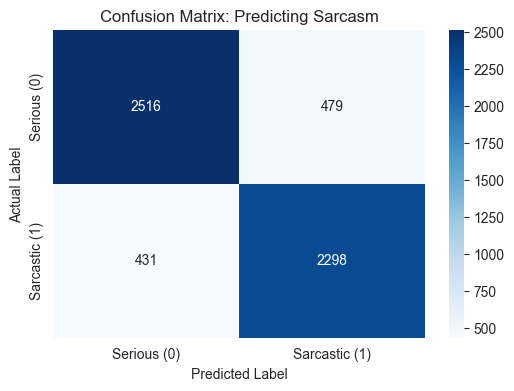

In [13]:
# Train Logistic Regression
# Added max_iter=1000 to ensure it finishes training on the larger dataset
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", model.score(X_test, y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Serious (0)', 'Sarcastic (1)'],
    yticklabels=['Serious (0)', 'Sarcastic (1)']
)
plt.title('Confusion Matrix: Predicting Sarcasm')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Interpreting the Confusion Matrix

While the overall accuracy score gives a good view of model performance, the confusion matrix breaks down exactly where the model succeeds and where it gets confused. 

In this 2x2 grid, the diagonal from top-left to bottom-right represents our correct predictions, while the other two quadrants represent our errors:

* **True Negatives (Top-Left):** The model correctly identified a serious *HuffPost* article (Class 0).
* **True Positives (Bottom-Right):** The model correctly identified a satirical *Onion* article (Class 1).
* **False Positives (Top-Right):** The model predicted "Sarcastic", but the article was actually "Serious". These errors often occur when real news uses sensationalized, extreme, or informal language that mimics satire.
* **False Negatives (Bottom-Left):** The model predicted "Serious", but the article was actually "Sarcastic". These errors highlight the model's lack of "world knowledge," as it fails to recognize the absurdity of a satirical premise if it is written using dry, standard journalistic vocabulary.

## 5. Evaluation & Error Analysis

A high accuracy score is great, but analyzing where the model exactly fails provides deeper insight into the limitations of our approach. Below we extract the False Positives (predicted sarcastic, actually serious) and False Negatives (predicted serious, actually sarcastic) to understand the model's blind spots.

### Critical Analysis & Limitations
By reviewing the misclassified headlines, we can identify key limitations:

1. **The "World Knowledge" Deficit (False Negatives):** TF-IDF models lack real-world context. Many *Onion* articles use completely standard, serious journalistic vocabulary, but the premise is absurd. Because the model only looks at word frequencies, it flags these as serious.
2. **The "Sensationalism" Overlap (False Positives):** Modern clickbait and sensationalized real news (*HuffPost*) often use extreme language, exclamation points, and bizarre phrasing. The model easily confuses this real-world sensationalism with satire.
3. **Tradeoffs:** While keeping stop words and using bigrams improved our ability to catch specific comedic phrases, TF-IDF ultimately treats text as a "bag of words." It loses the sequential flow and tone of the sentence. A more advanced architecture, such as a Transformer-based model (e.g., BERT), would be necessary to capture deeper semantic meaning and long-range dependencies.

In [14]:
# Create a DataFrame to compare actual vs. predicted labels for the test set
# We can use y_test.index to grab the exact original headlines!
results_df = pd.DataFrame({
    'headline': df.loc[y_test.index, 'headline'],
    'actual': y_test,
    'predicted': y_pred
})

# False Positives: Model said Sarcastic (1), Actual was Serious (0)
false_positives = results_df[(results_df['predicted'] == 1) & (results_df['actual'] == 0)]

# False Negatives: Model said Serious (0), Actual was Sarcastic (1)
false_negatives = results_df[(results_df['predicted'] == 0) & (results_df['actual'] == 1)]

print(f"Total False Positives: {len(false_positives)}")
print("Sample False Positives (Model thought it was satire, but it's real):")
display(false_positives.head(10))

print(f"\nTotal False Negatives: {len(false_negatives)}")
print("Sample False Negatives (Model thought it was real, but it's satire):")
display(false_negatives.head(10))

Total False Positives: 479
Sample False Positives (Model thought it was satire, but it's real):


,headline,actual,predicted
27927,states slow to shut down weak teacher educatio...,0,1
14361,massive filament snakes across sun's surface,0,1
19326,brad pitt goes completely gray for new movie,0,1
25600,magna carta: awesome tale,0,1
1288,most long island politician ever attacks oppon...,0,1
24528,gisele bundchen dons a nude bodysuit,0,1
3916,librarian who amassed millions by living humbl...,0,1
9291,artist transforms gallery into a basketball co...,0,1
852,powerball ticket sold with all winning numbers...,0,1
24320,"dave chappelle donates $50,000 from michigan s...",0,1



Total False Negatives: 431
Sample False Negatives (Model thought it was real, but it's satire):


,headline,actual,predicted
23948,track winnings reinvested in blackjack futures,1,0
5496,dude with knit hat at party calls beer 'libati...,1,0
13332,airline part of something called 'star alliance',1,0
28289,report: you live in an embarrassing country,1,0
7573,new teen trend 'walking wet and nude' couldn't...,1,0
11222,confused marines capture al-jazeera leader,1,0
21175,mom wants to know if the people who live in yo...,1,0
9296,pentagon officials listen in silence as mike p...,1,0
22434,kamala harris assembles campaign staff of unpa...,1,0
4519,u.s. to arab world: 'stop hating us or suffer ...,1,0


## Critical Analysis & Limitations

While the Logistic Regression model achieved strong overall accuracy, examining its errors reveals the inherent limitations of using TF-IDF for sarcasm detection:

**1. The "World Knowledge" Problem (False Negatives):**
Many sarcastic headlines (from *The Onion*) read exactly like serious news stylistically, but are sarcastic because the event described is absurd in the real world. For example, the model often misclassifies satirical articles about specific politicians or celebrities as "Serious" because it doesn't possess the real-world context to know that the stated action is a joke. It only sees standard news vocabulary.

**2. The "Sensationalism" Problem (False Positives):**
Real news (from *HuffPost*) can sometimes be so bizarre or heavily sensationalized that the model flags it as sarcastic. If a real news headline contains exclamation points, highly emotional language, or informal phrasing (which we intentionally kept during text preprocessing), the model heavily weighs those as satirical features.

**Tradeoffs of our Approach:**
While keeping stop words and using bigrams `ngram_range=(1,2)` helped capture phrases like "area man," TF-IDF still treats text as a "bag of words." It loses the broader sequence and tone of the entire sentence. A more advanced approach, such as a Transformer-based model (like BERT), would better capture the complex, long-range contextual dependencies required to truly "understand" sarcasm.